In [1]:
import pandas as pd

In [2]:
fin = pd.read_pickle('fin.pkl')
mc = pd.read_pickle('mc.pkl')
info = pd.read_pickle('info.pkl')

# 전략

* input = 날짜
* output = 종목별 투자비중

In [136]:
date = '2018-12-31' # input
fisyear = 2017
position = fin['매출액'].xs(fisyear, level=1).nlargest(10)
position[:] = 1/len(position); position # output; [:] 빼면 될까 안될까

A005930    0.1
A005380    0.1
A034730    0.1
A066570    0.1
A005490    0.1
A015760    0.1
A000270    0.1
A000880    0.1
A096770    0.1
A012330    0.1
Name: 매출액, dtype: float64

### date → fisyear

In [41]:
date = pd.Timestamp(date)
if date.month >=6: 
    fisyear = date.year - 1
else:
    fisyear = date.year - 2

In [3]:
def get_fisyear(date):
    date = pd.Timestamp(date)
    
    if date.month >=6: 
        return date.year - 1
    else:
        return date.year - 2

In [4]:
def 매출상위(date, fin, n=10):
    fisyear = get_fisyear(date)
    position = fin['매출액'].xs(fisyear, level=1).nlargest(n)
    position[:] = 1/len(position)
    return position

# 벡테스터
매 리밸런싱 마다 포지션을 잡고, 주기적으로 포지션 가치를 계산하면 된다

In [55]:
dates = mc.index[8:]

In [143]:
for date in dates:
#     print(date)
    pass

In [71]:
pos = {}
nav = {}
for date in dates:
    pos[date] = 매출상위(date, fin)
    # nav[date] = 내 계좌의 가치기록, HOW?

### 내 계좌의 가치(NAV) 계산은 어떻게?
* 전 리밸일 기준 포지션 전체가치 = nav_prev (given)
* 전 리밸일 포지션별 = pos_prev (given)
* 전 리밸일 포지션별 가치 = nav_prev * pos_prev
* 전 리밸일 이후 포지션 가치변화 = 현재시총 / 전 리밸일 시총
* 전 리밸일 포지션의 현재가치 = nav_prev * pos_prev * 현재시총 / 전 리밸일 시총
* 현재 리밸일 기준 포지션 전체가치 = sum(전 리밸일 포지션의 현재가치)

In [73]:
pos = {}
nav = {}
for i, date in enumerate(dates):
    pos[date] = 매출상위(date, fin)
    
    date_prev = dates[i-1]
    nav_prev = nav[date_prev]
    pos_prev = pos[date_prev]
    assets_prev = pos_prev.index
    mc_chg = mc.loc[date, assets_prev] / mc.loc[date_prev, assets_prev]
    nav_pos_prev = nav_prev * pos_prev * mc_chg
    nav[date] = nav_pos_prev.sum()

KeyError: Timestamp('2019-03-31 00:00:00')

In [75]:
pos = {}
nav = {}
for i, date in enumerate(dates):
    pos[date] = 매출상위(date, fin)
    
    if i==0:
        nav[date] = 1
        
    else:
        date_prev = dates[i-1]
        nav_prev = nav[date_prev]
        pos_prev = pos[date_prev]
        assets_prev = pos_prev.index
        mc_chg = mc.loc[date, assets_prev] / mc.loc[date_prev, assets_prev]
        nav_pos_prev = nav_prev * pos_prev * mc_chg
        nav[date] = nav_pos_prev.sum()

In [144]:
nav;

In [84]:
from IPython.core.debugger import set_trace

In [87]:
pos = {}
nav = {}

def 내계좌는얼마(nav, pos, date, date_prev, mc):
    nav_prev = nav[date_prev]
    pos_prev = pos[date_prev]
    assets_prev = pos_prev.index
    mc_chg = mc.loc[date, assets_prev] / mc.loc[date_prev, assets_prev]
    nav_pos_prev = nav_prev * pos_prev * mc_chg
    return nav_pos_prev.sum()

for i, date in enumerate(dates):
#     set_trace()
    pos[date] = 매출상위(date, fin)
    
    if i==0:
        nav[date] = 1
        
    else:
        date_prev = dates[i-1]
        nav[date] = 내계좌는얼마(nav, pos, date, date_prev, mc)

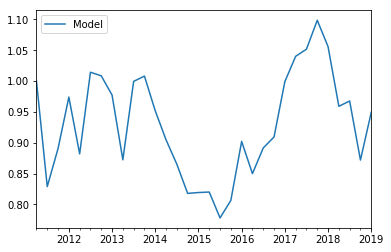

In [90]:
pd.DataFrame({'Model':nav}).plot()

### BM 전략도 만들어보자
시총상위 200개 종목을 시총가중

In [145]:
position = mc.loc[date].nlargest(200)
position / position.sum();

In [5]:
def BM(date, fin=None, mc=None, n=200):
    position = mc.loc[date].nlargest(n)
    position = position / position.sum()
    return position

def 매출상위(date, fin=None, mc=None, n=10):
    fisyear = get_fisyear(date)
    position = fin['매출액'].xs(fisyear, level=1).nlargest(n)
    position[:] = 1/len(position)
    return position

In [95]:
BM('2018-12-31', mc=mc);

In [125]:
pos = {}
nav = {}
pos_bm = {}
nav_bm = {}
n = 10

for i, date in enumerate(dates):
    pos[date] = 매출상위(date, fin=fin, mc=mc, n=n)
    pos_bm[date] = BM(date, fin=fin, mc=mc)
    
    if i==0:
        nav[date] = 1
        nav_bm[date] = 1
        
    else:
        date_prev = dates[i-1]
        nav[date] = 내계좌는얼마(nav, pos, date, date_prev, mc)
        nav_bm[date] = 내계좌는얼마(nav_bm, pos_bm, date, date_prev, mc)

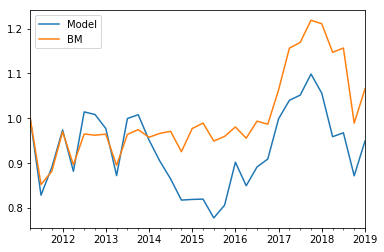

In [99]:
pd.DataFrame({'Model':nav, 'BM':nav_bm}).plot()

# 좀더 고급진 백테스터

* 전략 = 설계도
* 벡테스터 = Backtest(어떤전략, BM, DB, 기타옵션들...)
* 백테스터.run()
* 백테스터.plot() ...

In [100]:
class Backtest:
    def __init__(self, model=None, bm=None, fin=None, mc=None, n=10):
        self.model = model
        self.bm = bm
        self.fin = fin
        self.mc = mc
        self.n = n

In [102]:
bt = Backtest(model=매출상위, bm=BM, fin=fin, mc=mc, n=10)

In [103]:
bt.bm

<function __main__.BM(date, fin=None, mc=None, n=200)>

In [137]:
import inspect
inspect.getsource(bt.bm)

'def BM(date, fin=None, mc=None, n=200):\n    position = mc.loc[date].nlargest(n)\n    position = position / position.sum()\n    return position\n'

In [12]:
class Backtest:
    def __init__(self, model=None, bm=None, fin=None, mc=None, n=10):
        self.model = model
        self.bm = bm
        self.fin = fin
        self.mc = mc
        self.n = n
        
    # fin, mc, n, 내계좌는 얼마.를 self. 로
    # pos, nav, pos_bm, nav_bm를 self 저장
    def run(self):
        dates = mc.index[8:]
        pos = {}
        nav = {}
        pos_bm = {}
        nav_bm = {}

        for i, date in enumerate(tqdm_notebook(dates)):
            pos[date] = self.model(date, fin=self.fin, mc=self.mc, n=self.n)
            pos_bm[date] = self.bm(date, fin=self.fin, mc=self.mc)

            if i==0:
                nav[date] = 1
                nav_bm[date] = 1

            else:
                date_prev = dates[i-1]
                nav[date] = self.내계좌는얼마(nav, pos, date, date_prev)
                nav_bm[date] = self.내계좌는얼마(nav_bm, pos_bm, date, date_prev)
                
        self.pos = pos
        self.nav = nav
        self.pos_bm = pos_bm
        self.nav_bm = nav_bm
                
                
    # mc를 self.mc로
    def 내계좌는얼마(self, nav, pos, date, date_prev):
        nav_prev = nav[date_prev]
        pos_prev = pos[date_prev]
        assets_prev = pos_prev.index
        mc_chg = self.mc.loc[date, assets_prev] / self.mc.loc[date_prev, assets_prev]
        nav_pos_prev = nav_prev * pos_prev * mc_chg
        return nav_pos_prev.sum()
    
    
    def navs(self):
        return pd.DataFrame({'Model':self.nav, 'BM':self.nav_bm})
    
    # plot_perf() 추가
    def plot_perf(self):
        self.navs().plot()
        
    # 성과평가 추가
    def stats(self):
        _navs = self.navs()
        ndays = (_navs.index[-1]-_navs.index[0]).days
        ann_rtn = (_navs.iloc[-1]**(365/ndays)) - 1
        vol = _navs.pct_change().std() * (4**0.5)
        return pd.DataFrame({
            'Annual return': ann_rtn, 
            'Volatility': vol, 
            'Sharpe': ann_rtn/vol
        })

### plot_perf() 추가

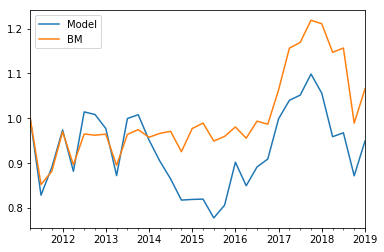

In [13]:
bt = Backtest(model=매출상위, bm=BM, fin=fin, mc=mc, n=10)
bt.run()
bt.plot_perf()

### tqdm 추가

In [14]:
from tqdm import tqdm_notebook

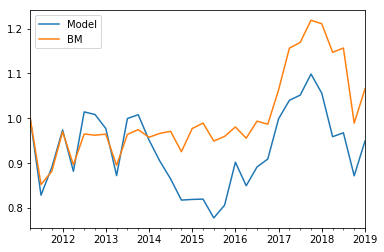

In [121]:
bt = Backtest(model=매출상위, bm=BM, fin=fin, mc=mc, n=10)
bt.run()
bt.plot_perf()

### 성과평가
* (1+R)^(총연수) = 최종nav
* R = (최종nav)^(1/총연수) - 1

In [124]:
bt = Backtest(model=매출상위, bm=BM, fin=fin, mc=mc, n=10)
bt.run()
bt.stats()

,Annual return,Volatility,Sharpe
Model,-0.006684,0.156904,-0.042602
BM,0.008227,0.121585,0.067661


# 새로운 전략 생성

In [129]:
def 시총높고PB저평가(date, fin=None, mc=None, n=10):
    fisyear = get_fisyear(date)
    marketcap = mc.loc[date].nlargest(100)
    univ = marketcap.index
    bv = fin['자본총계'].xs(fisyear, level=1).loc[univ]
    bp = bv / marketcap
    position = bp.nlargest(n)
    position[:] = 1/len(position)
    return position

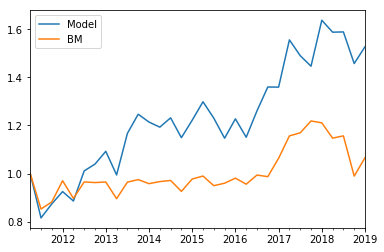

In [134]:
bt = Backtest(model=시총높고PB저평가, bm=BM, fin=fin, mc=mc, n=10)
bt.run()
bt.plot_perf()